In [1]:
import numpy as np
import pandas as pd

import missingno as msno 
import string 
import seaborn as sns 
import matplotlib.pyplot as plt

import scipy.optimize as opt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import scipy.stats as sps
from matplotlib_venn import venn3
from supervenn import supervenn
import json
import csv

import re    # for regular expressions 
import string

import glob, os
from epss_api import EPSS

from scipy import stats
from scipy.stats import gamma
from scipy.special import gamma as gamma_function
from scipy.stats import expon
from scipy.stats import beta

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
csv.field_size_limit(100000000)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

***
## Data Preprocessing
***

Datasets used in this analysis include CISA KEV, CVSS Scores, and EPSS Scores for CVEs.
The fields are formatted according to their appropriate types and merged into a single dataframe, joined on CVE_ID.

In [3]:
kev = pd.read_csv('kev.csv', encoding = 'utf-8-sig', engine = 'python')

In [4]:
kev.head(1)

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes
0,CVE-2021-27104,Accellion,FTA,Accellion FTA OS Command Injection Vulnerability,2021-11-03,Accellion FTA contains an OS command injection...,Apply updates per vendor instructions.,2021-11-17,Known,NaN


In [5]:
kev['hasKEV'] = kev['cveID'].apply(lambda x : 1)

In [6]:
kev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   cveID                       1025 non-null   object
 1   vendorProject               1025 non-null   object
 2   product                     1024 non-null   object
 3   vulnerabilityName           1025 non-null   object
 4   dateAdded                   1025 non-null   object
 5   shortDescription            1025 non-null   object
 6   requiredAction              1025 non-null   object
 7   dueDate                     1025 non-null   object
 8   knownRansomwareCampaignUse  1025 non-null   object
 9   notes                       258 non-null    object
 10  hasKEV                      1025 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 88.2+ KB


In [7]:
client = EPSS()
values = client.scores()

In [8]:
cve = pd.read_csv('allitems.csv', encoding = 'utf-8-sig', engine = 'python')

In [9]:
cve.head()

,Name,Status,Description,References,Phase,Votes,Comments
0,CVE-1999-0001,Candidate,ip_input.c in BSD-derived TCP/IP implementatio...,BUGTRAQ:19981223 Re: CERT Advisory CA-98.13 - ...,Modified (20051217),"MODIFY(1) Frech | NOOP(2) Northcutt, Wall...",Christey> A Bugtraq posting indicates that the...
1,CVE-1999-0002,Entry,Buffer overflow in NFS mountd gives root acces...,BID:121 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
2,CVE-1999-0003,Entry,Execute commands as root via buffer overflow i...,BID:122 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
3,CVE-1999-0004,Candidate,"MIME buffer overflow in email clients, e.g. So...",CERT:CA-98.10.mime_buffer_overflows | MS:M...,Modified (19990621),"ACCEPT(8) Baker, Cole, Collins, Dik, Landfield...","Frech> Extremely minor, but I believe e-mail i..."
4,CVE-1999-0005,Entry,Arbitrary command execution via IMAP buffer ov...,BID:130 | URL:http://www.securityfocus.com...,NaN,NaN,NaN


In [10]:
candidates = cve[cve.Status == 'Candidate']

In [11]:
# remove candidates
cve = cve[cve.Status == 'Entry']

In [12]:
# df['epssScore'] = df['cveID'].apply(lambda x : client.score(cve_id=x))
epss = pd.read_csv('latest-epss-scores.csv', encoding = 'utf-8-sig', engine = 'python')

In [13]:
epss.head(1)

,cve,epss,percentile
0,CVE-2014-0160,0.97588,1.0


In [14]:
def get_files_from_path(path: str='.', extension: str=None) -> list:
    """return list of files from path"""
    # https://stackoverflow.com/a/41447012/9267296
    result = []
    for subdir, dirs, files in os.walk(path):
        for filename in files:
            filepath = subdir + os.sep + filename
            if extension == None:
                result.append(filepath)
            elif filename.lower().endswith(extension.lower()):
                result.append(filepath)
    return result

In [15]:
cvss = pd.DataFrame()

In [16]:
filelist = get_files_from_path(extension='.json')
alldata = []
for filepath in filelist:
    with open(filepath) as infile:
#         jsonlist.append(json.load(infile))
        data = json.load(infile)
#         alldata.append(data)
        df = pd.DataFrame(data)
        df = pd.json_normalize(df["CVE_Items"])
        cvss = cvss.append(df,ignore_index=True)

In [17]:
cvss.tail(10)

,publishedDate,lastModifiedDate,cve.data_type,cve.data_format,cve.data_version,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
335622,2020-12-08T20:15Z,2023-01-09T16:41Z,CVE,MITRE,4.0,CVE-2020-9989,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://support.apple.com/en-us/HT21...,"[{'lang': 'en', 'value': 'The issue was addres...",...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
335623,2020-10-22T19:15Z,2022-05-03T16:04Z,CVE,MITRE,4.0,CVE-2020-9990,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://support.apple.com/kb/HT21128...,"[{'lang': 'en', 'value': 'A race condition was...",...,COMPLETE,6.9,MEDIUM,3.4,10.0,False,False,False,False,False
335624,2020-12-08T22:15Z,2023-11-07T03:27Z,CVE,MITRE,4.0,CVE-2020-9991,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://support.apple.com/en-us/HT21...,"[{'lang': 'en', 'value': 'This issue was addre...",...,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,False
335625,2020-10-16T17:15Z,2023-01-09T16:41Z,CVE,MITRE,4.0,CVE-2020-9992,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'NVD...","[{'url': 'https://support.apple.com/HT211850',...","[{'lang': 'en', 'value': 'This issue was addre...",...,COMPLETE,9.3,HIGH,8.6,10.0,False,False,False,False,True
335626,2020-12-08T20:15Z,2023-01-09T16:41Z,CVE,MITRE,4.0,CVE-2020-9993,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://support.apple.com/en-us/HT21...,"[{'lang': 'en', 'value': 'The issue was addres...",...,NONE,4.3,MEDIUM,8.6,2.9,False,False,False,False,True
335627,2020-10-22T19:15Z,2020-10-26T20:26Z,CVE,MITRE,4.0,CVE-2020-9994,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://support.apple.com/kb/HT21116...,"[{'lang': 'en', 'value': 'A path handling issu...",...,PARTIAL,5.8,MEDIUM,8.6,4.9,False,False,False,False,True
335628,2021-04-02T18:15Z,2021-04-07T20:25Z,CVE,MITRE,4.0,CVE-2020-9995,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://support.apple.com/en-us/HT21...,"[{'lang': 'en', 'value': 'An issue existed in ...",...,NONE,5.8,MEDIUM,8.6,4.9,False,False,False,False,True
335629,2020-12-08T20:15Z,2023-01-09T16:41Z,CVE,MITRE,4.0,CVE-2020-9996,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://support.apple.com/en-us/HT21...,"[{'lang': 'en', 'value': 'A use after free iss...",...,PARTIAL,6.8,MEDIUM,8.6,6.4,False,False,False,False,True
335630,2020-10-22T19:15Z,2020-10-26T20:27Z,CVE,MITRE,4.0,CVE-2020-9997,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://support.apple.com/kb/HT21128...,"[{'lang': 'en', 'value': 'An information discl...",...,NONE,4.3,MEDIUM,8.6,2.9,False,False,False,False,True
335631,2020-12-08T20:15Z,2021-07-21T11:39Z,CVE,MITRE,4.0,CVE-2020-9999,product-security@apple.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://support.apple.com/en-us/HT21...,"[{'lang': 'en', 'value': 'A memory corruption ...",...,PARTIAL,6.8,MEDIUM,8.6,6.4,False,False,False,False,True


In [18]:
cvss.head(10)

,publishedDate,lastModifiedDate,cve.data_type,cve.data_format,cve.data_version,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
0,2021-06-09T20:15Z,2021-06-28T18:03Z,CVE,MITRE,4.0,CVE-2021-0001,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Observable timing di...",...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
1,2021-08-11T13:15Z,2021-11-30T19:43Z,CVE,MITRE,4.0,CVE-2021-0002,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper conditions ...",...,PARTIAL,3.6,LOW,3.9,4.9,False,False,False,False,False
2,2021-08-11T13:15Z,2021-09-14T18:36Z,CVE,MITRE,4.0,CVE-2021-0003,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper conditions ...",...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
3,2021-08-11T13:15Z,2022-03-31T19:45Z,CVE,MITRE,4.0,CVE-2021-0004,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper buffer rest...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
4,2021-08-11T13:15Z,2021-09-14T18:36Z,CVE,MITRE,4.0,CVE-2021-0005,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Uncaught exception i...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
5,2021-08-11T13:15Z,2021-09-14T18:35Z,CVE,MITRE,4.0,CVE-2021-0006,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Improper conditions ...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
6,2021-08-11T13:15Z,2021-09-14T18:35Z,CVE,MITRE,4.0,CVE-2021-0007,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Uncaught exception i...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
7,2021-08-11T13:15Z,2021-09-14T18:34Z,CVE,MITRE,4.0,CVE-2021-0008,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Uncontrolled resourc...",...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
8,2021-08-11T13:15Z,2021-09-14T18:34Z,CVE,MITRE,4.0,CVE-2021-0009,secure@intel.com,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'https://www.intel.com/content/www/us...,"[{'lang': 'en', 'value': 'Out-of-bounds read i...",...,NONE,3.3,LOW,6.5,2.9,False,False,False,False,False
9,2023-05-16T22:15Z,2023-05-16T22:15Z,CVE,MITRE,4.0,CVE-2021-0010,cve@mitre.org,[{'description': []}],[],"[{'lang': 'en', 'value': '** REJECT ** DO NOT ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
cvss = cvss.infer_objects()

In [20]:
cvss.lastModifiedDate = pd.to_datetime(cvss.lastModifiedDate)
cvss.publishedDate = pd.to_datetime(cvss.publishedDate)

In [21]:
# remove columns with high cardinality 
drop_these = ['cve.data_version', 'cve.data_type', 'cve.data_format', 'cve.references.reference_data', 'cve.problemtype.problemtype_data', 'cve.description.description_data', 'configurations.CVE_data_version']
cvss = cvss.drop(columns=drop_these)

In [22]:
cvss.tail(10)

,publishedDate,lastModifiedDate,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,configurations.nodes,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
335622,2020-12-08 20:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9989,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
335623,2020-10-22 19:15:00+00:00,2022-05-03 16:04:00+00:00,CVE-2020-9990,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:H/PR:L/UI:N/S:C/C:H/I:H/A:H,LOCAL,HIGH,LOW,...,COMPLETE,6.9,MEDIUM,3.4,10.0,False,False,False,False,False
335624,2020-12-08 22:15:00+00:00,2023-11-07 03:27:00+00:00,CVE-2020-9991,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,NETWORK,LOW,NONE,...,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,False
335625,2020-10-16 17:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9992,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,...,COMPLETE,9.3,HIGH,8.6,10.0,False,False,False,False,True
335626,2020-12-08 20:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9993,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:L/A:N,NETWORK,LOW,NONE,...,NONE,4.3,MEDIUM,8.6,2.9,False,False,False,False,True
335627,2020-10-22 19:15:00+00:00,2020-10-26 20:26:00+00:00,CVE-2020-9994,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:H,LOCAL,LOW,NONE,...,PARTIAL,5.8,MEDIUM,8.6,4.9,False,False,False,False,True
335628,2021-04-02 18:15:00+00:00,2021-04-07 20:25:00+00:00,CVE-2020-9995,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,...,NONE,5.8,MEDIUM,8.6,4.9,False,False,False,False,True
335629,2020-12-08 20:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9996,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,...,PARTIAL,6.8,MEDIUM,8.6,6.4,False,False,False,False,True
335630,2020-10-22 19:15:00+00:00,2020-10-26 20:27:00+00:00,CVE-2020-9997,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,LOCAL,LOW,NONE,...,NONE,4.3,MEDIUM,8.6,2.9,False,False,False,False,True
335631,2020-12-08 20:15:00+00:00,2021-07-21 11:39:00+00:00,CVE-2020-9999,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,...,PARTIAL,6.8,MEDIUM,8.6,6.4,False,False,False,False,True


In [23]:
# might have to remove them later on though
cvss['impact.baseMetricV3.cvssV3.baseScore'].fillna(0, inplace=True)
cvss['impact.baseMetricV2.cvssV2.baseScore'].fillna(0, inplace=True)

In [24]:
cvss.head(10)

,publishedDate,lastModifiedDate,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,configurations.nodes,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,...,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.acInsufInfo,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired
0,2021-06-09 20:15:00+00:00,2021-06-28 18:03:00+00:00,CVE-2021-0001,secure@intel.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:H/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,HIGH,LOW,...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
1,2021-08-11 13:15:00+00:00,2021-11-30 19:43:00+00:00,CVE-2021-0002,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:H,LOCAL,LOW,LOW,...,PARTIAL,3.6,LOW,3.9,4.9,False,False,False,False,False
2,2021-08-11 13:15:00+00:00,2021-09-14 18:36:00+00:00,CVE-2021-0003,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,...,NONE,2.1,LOW,3.9,2.9,False,False,False,False,False
3,2021-08-11 13:15:00+00:00,2022-03-31 19:45:00+00:00,CVE-2021-0004,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
4,2021-08-11 13:15:00+00:00,2021-09-14 18:36:00+00:00,CVE-2021-0005,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
5,2021-08-11 13:15:00+00:00,2021-09-14 18:35:00+00:00,CVE-2021-0006,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
6,2021-08-11 13:15:00+00:00,2021-09-14 18:35:00+00:00,CVE-2021-0007,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
7,2021-08-11 13:15:00+00:00,2021-09-14 18:34:00+00:00,CVE-2021-0008,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:L/AC:L/PR:H/UI:N/S:U/C:N/I:N/A:H,LOCAL,LOW,HIGH,...,PARTIAL,2.1,LOW,3.9,2.9,False,False,False,False,False
8,2021-08-11 13:15:00+00:00,2021-09-14 18:34:00+00:00,CVE-2021-0009,secure@intel.com,"[{'operator': 'AND', 'children': [{'operator':...",3.1,CVSS:3.1/AV:A/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,ADJACENT_NETWORK,LOW,NONE,...,NONE,3.3,LOW,6.5,2.9,False,False,False,False,False
9,2023-05-16 22:15:00+00:00,2023-05-16 22:15:00+00:00,CVE-2021-0010,cve@mitre.org,[],NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cvss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335632 entries, 0 to 335631
Data columns (total 36 columns):
 #   Column                                            Non-Null Count   Dtype              
---  ------                                            --------------   -----              
 0   publishedDate                                     335632 non-null  datetime64[ns, UTC]
 1   lastModifiedDate                                  335632 non-null  datetime64[ns, UTC]
 2   cve.CVE_data_meta.ID                              335632 non-null  object             
 3   cve.CVE_data_meta.ASSIGNER                        335632 non-null  object             
 4   configurations.nodes                              335632 non-null  object             
 5   impact.baseMetricV3.cvssV3.version                242642 non-null  object             
 6   impact.baseMetricV3.cvssV3.vectorString           242642 non-null  object             
 7   impact.baseMetricV3.cvssV3.attackVector           242642

In [26]:
# remove version 2 references and columns, likely superseeded by version 3
drop_these = ['impact.baseMetricV2.cvssV2.version', 
              'impact.baseMetricV2.cvssV2.vectorString',  
              'impact.baseMetricV2.cvssV2.accessVector',   
              'impact.baseMetricV2.cvssV2.accessComplexity',
              'impact.baseMetricV2.cvssV2.authentication',    
              'impact.baseMetricV2.cvssV2.confidentialityImpact',  
              'impact.baseMetricV2.cvssV2.integrityImpact',       
              'impact.baseMetricV2.cvssV2.availabilityImpact',    
              'impact.baseMetricV2.cvssV2.baseScore',         
              'impact.baseMetricV2.severity',                 
              'impact.baseMetricV2.exploitabilityScore', 
              'impact.baseMetricV2.impactScore', 
              'impact.baseMetricV2.acInsufInfo',   
              'impact.baseMetricV2.obtainAllPrivilege', 
              'impact.baseMetricV2.obtainUserPrivilege', 
              'impact.baseMetricV2.obtainOtherPrivilege',
              'impact.baseMetricV2.userInteractionRequired'] 
cvss = cvss.drop(columns=drop_these)

In [27]:
cvss.shape

(335632, 19)

In [28]:
kev.shape

(1025, 11)

In [29]:
cvss = cvss.rename(columns={'cve.CVE_data_meta.ID': 'cveID', 'cve.CVE_data_meta.ASSIGNER': 'assigner', 'impact.baseMetricV3.cvssV3.baseScore' : 'cvssScore'})

In [30]:
# cvss.rename(columns = lambda x: x.replace('impact.baseMetricV3.$', ''))
cvss.columns = cvss.columns.map(lambda x: x.removeprefix('impact.baseMetricV3.')) 
cvss.columns = cvss.columns.map(lambda x: x.removeprefix('impact.baseMetricV2.')) 
cvss.columns

Index(['publishedDate', 'lastModifiedDate', 'cveID', 'assigner',
       'configurations.nodes', 'cvssV3.version', 'cvssV3.vectorString',
       'cvssV3.attackVector', 'cvssV3.attackComplexity',
       'cvssV3.privilegesRequired', 'cvssV3.userInteraction', 'cvssV3.scope',
       'cvssV3.confidentialityImpact', 'cvssV3.integrityImpact',
       'cvssV3.availabilityImpact', 'cvssScore', 'cvssV3.baseSeverity',
       'exploitabilityScore', 'impactScore'],
      dtype='object')

In [31]:
epss = epss.rename(columns = {'cve' : 'cveID'})

In [32]:
df = pd.merge(cvss, kev, on = 'cveID', how = 'left')

In [33]:
df = pd.merge(df, epss, on = 'cveID', how = 'left')

In [34]:
df.columns = df.columns.map(lambda x: x.removeprefix('cvssV3.')) 
df.columns

Index(['publishedDate', 'lastModifiedDate', 'cveID', 'assigner',
       'configurations.nodes', 'version', 'vectorString', 'attackVector',
       'attackComplexity', 'privilegesRequired', 'userInteraction', 'scope',
       'confidentialityImpact', 'integrityImpact', 'availabilityImpact',
       'cvssScore', 'baseSeverity', 'exploitabilityScore', 'impactScore',
       'vendorProject', 'product', 'vulnerabilityName', 'dateAdded',
       'shortDescription', 'requiredAction', 'dueDate',
       'knownRansomwareCampaignUse', 'notes', 'hasKEV', 'epss', 'percentile'],
      dtype='object')

***
### Exploratory Data Analysis
***

In [35]:
df.shape

(335632, 31)

In [36]:
df.describe()

,cvssScore,exploitabilityScore,impactScore,hasKEV,epss,percentile
count,335632.000000,242642.000000,242642.000000,1660.0,314615.000000,314615.000000
mean,5.186888,2.681916,4.352068,1.0,0.028805,0.461652
std,3.515337,0.957215,1.526150,0.0,0.132597,0.278337
min,0.000000,0.100000,1.400000,1.0,0.000420,0.004490
25%,0.000000,1.800000,3.600000,1.0,0.000560,0.216370
50%,6.100000,2.800000,3.600000,1.0,0.001080,0.435390
75%,7.800000,3.900000,5.900000,1.0,0.003590,0.691270
max,10.000000,3.900000,6.000000,1.0,0.975880,1.000000


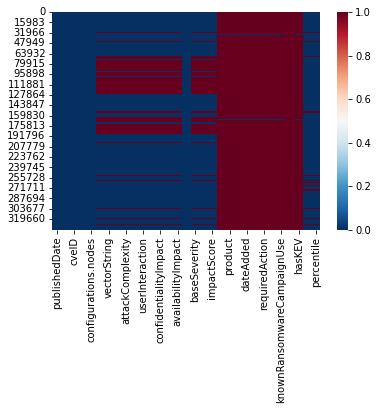

In [37]:
sns.heatmap(df.isnull(), cmap="RdBu_r")
plt.show()

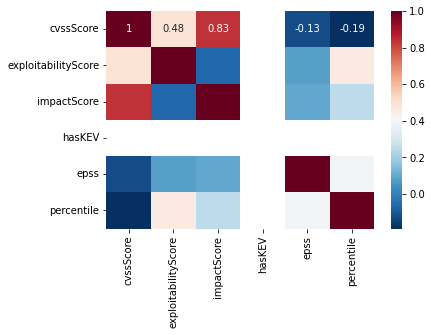

In [38]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r")
plt.show()

In [39]:
df.lastModifiedDate = pd.to_datetime(df.lastModifiedDate)
df.publishedDate = pd.to_datetime(df.publishedDate)
df.dueDate = pd.to_datetime(df.dueDate)

In [40]:
least_recent_date = df.publishedDate.min()
least_recent_date

Timestamp('1988-10-01 04:00:00+0000', tz='UTC')

In [41]:
most_recent_date = df.publishedDate.max()
most_recent_date

Timestamp('2023-12-15 05:15:00+0000', tz='UTC')

In [42]:
df['publishedYear'] = df['publishedDate'].apply(lambda x : x.year)

In [43]:
df['publishedMonth'] = df['publishedDate'].apply(lambda x : x.month)

In [44]:
z = df['publishedMonth'].value_counts()

z1 = z.to_dict() #converts to dictionary

df['count'] = df['publishedMonth'].map(z1)

In [45]:
df.tail(10)

,publishedDate,lastModifiedDate,cveID,assigner,configurations.nodes,version,vectorString,attackVector,attackComplexity,privilegesRequired,...,requiredAction,dueDate,knownRansomwareCampaignUse,notes,hasKEV,epss,percentile,publishedYear,publishedMonth,count
335622,2020-12-08 20:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9989,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,LOW,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00042,0.05714,2020,12,30600
335623,2020-10-22 19:15:00+00:00,2022-05-03 16:04:00+00:00,CVE-2020-9990,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:H/PR:L/UI:N/S:C/C:H/I:H/A:H,LOCAL,HIGH,LOW,...,NaN,NaT,NaN,NaN,NaN,0.00045,0.13059,2020,10,29995
335624,2020-12-08 22:15:00+00:00,2023-11-07 03:27:00+00:00,CVE-2020-9991,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,NETWORK,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00578,0.75615,2020,12,30600
335625,2020-10-16 17:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9992,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00108,0.43542,2020,10,29995
335626,2020-12-08 20:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9993,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:L/A:N,NETWORK,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00101,0.41254,2020,12,30600
335627,2020-10-22 19:15:00+00:00,2020-10-26 20:26:00+00:00,CVE-2020-9994,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:H/A:H,LOCAL,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00073,0.30652,2020,10,29995
335628,2021-04-02 18:15:00+00:00,2021-04-07 20:25:00+00:00,CVE-2020-9995,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:N,NETWORK,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00070,0.29252,2021,4,28706
335629,2020-12-08 20:15:00+00:00,2023-01-09 16:41:00+00:00,CVE-2020-9996,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00102,0.41556,2020,12,30600
335630,2020-10-22 19:15:00+00:00,2020-10-26 20:27:00+00:00,CVE-2020-9997,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,LOCAL,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00065,0.27340,2020,10,29995
335631,2020-12-08 20:15:00+00:00,2021-07-21 11:39:00+00:00,CVE-2020-9999,product-security@apple.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,LOCAL,LOW,NONE,...,NaN,NaT,NaN,NaN,NaN,0.00173,0.54381,2020,12,30600


In [46]:
df['epss'].fillna(0, inplace=True)

In [47]:
df['hasKEV'].fillna(0, inplace=True)

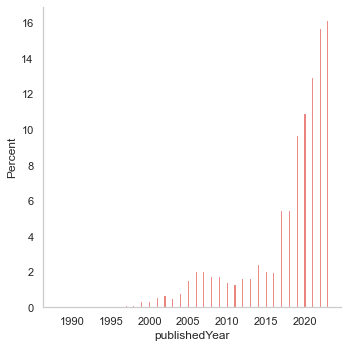

In [48]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.displot(x= 'publishedYear', data=df, stat='percent')

An immediate first reaction would be to conclude that the threat proliferation is increasing exponentially over time.

A time series is broadly classified into three categories of long-term fluctuations, short-term or periodic fluctuations, and random variations. A long-term variation or a trend shows the general tendency of the data to increase or decrease during a long period of time. The variation may be gradual but it is inevitably present.

<Axes: xlabel='publishedYear', ylabel='count'>

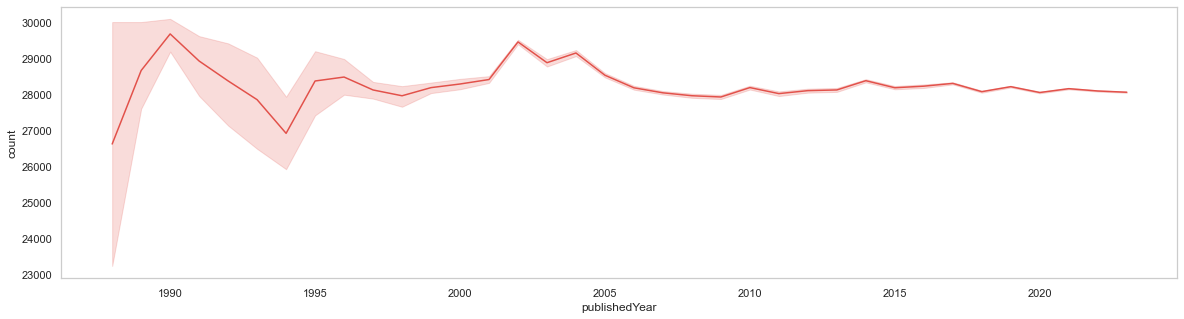

In [49]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.lineplot('publishedYear', 'count', data=df)

The moving average is commonly used with time series to smooth random short-term variations and to highlight other components (trend, season, or cycle) present in your data. The moving average is also known as rolling mean and is calculated by averaging data of the time series within k periods of time.

This method uses the concept of ironing out the fluctuations of the data by taking the means. It measures the trend by eliminating the changes or the variations by means of a moving average. The simplest of the mean used for the measurement of a trend is the arithmetic means (averages).

In [50]:
cve_gr = pd.DataFrame({'count' : df.groupby( [ "publishedYear", "publishedMonth"] ).size()}).reset_index()

In [51]:
cve_gr['count'] = cve_gr['count'].replace(0, 1)

The simple moving average is the unweighted mean of the previous M data points. The selection of M (sliding window) depends on the amount of smoothing desired since increasing the value of M improves the smoothing at the expense of accuracy.

In [52]:
rolling = df.publishedDate.dt.to_period('M').sort_index().value_counts()

/var/folders/81/jyd7r7j97q36mxrppmmkm7qw0000gn/T/ipykernel_7973/2377251798.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  rolling = df.publishedDate.dt.to_period('M').sort_index().value_counts()


In [53]:
rolling.index = rolling.index.to_timestamp()
rolling = rolling.sort_index()
rolling[rolling.index] = np.cumsum(rolling.values)
rolling = rolling.rolling(12, axis=0).sum().pct_change(axis=0)

<Axes: >

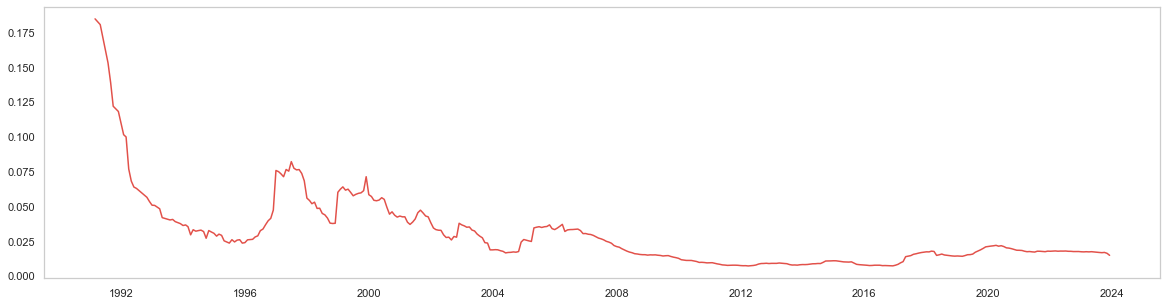

In [54]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
sns.lineplot(x=rolling.index, y=rolling.values)

While the treat proliferation seems to increase exponentially, the moving average suggests a different trend, which is that while new threats appear every year, the trend points to a stabilization of the number of new threats per years.

In [55]:
y = df.cvssScore.sort_values().astype('int').value_counts().sort_index()[1:]

[Text(0, 0, '0.0%'),
 Text(0, 0, '0.4%'),
 Text(0, 0, '1.4%'),
 Text(0, 0, '7.7%'),
 Text(0, 0, '16.6%'),
 Text(0, 0, '17.0%'),
 Text(0, 0, '28.1%'),
 Text(0, 0, '13.5%'),
 Text(0, 0, '15.1%'),
 Text(0, 0, '0.2%')]

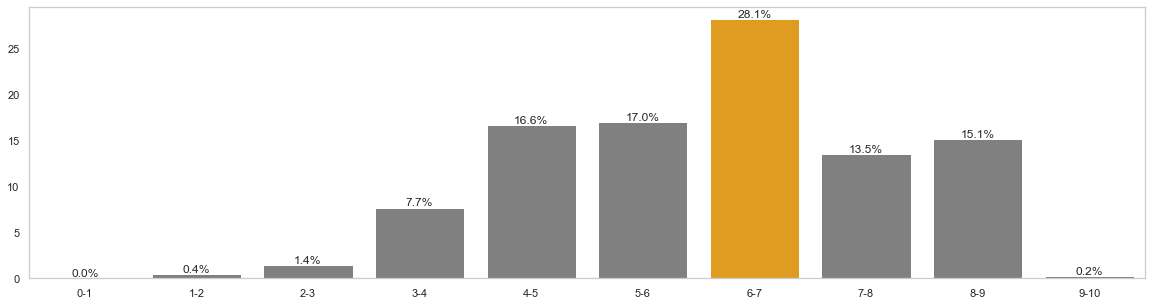

In [56]:
#define figure size
sns.set(rc={"figure.figsize":(20, 5)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette("Spectral")
#use orange for bar with max value and grey for all other bars
cols = ['grey' if (x < max(y.values)) else 'orange' for x in y.values]

ax = sns.barplot(x=y.index.map(lambda x: "{}-{}".format(x-1,x)), y=y.values/np.sum(y.values)*100, palette=cols)
ax.bar_label(ax.containers[0], fmt='%.1f%%')

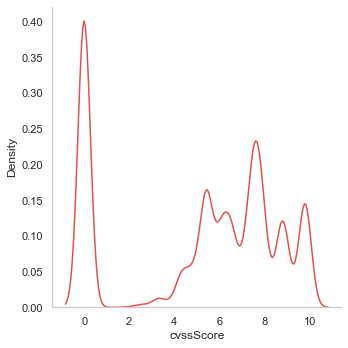

In [57]:
sns.displot(df, x="cvssScore", kind="kde")

In [58]:
y = df.epss.sort_values().astype('float').value_counts().sort_index()[1:]

In [59]:
df['epss'].describe()

count    335632.000000
mean          0.027001
std           0.128568
min           0.000000
25%           0.000500
50%           0.000980
75%           0.003170
max           0.975880
Name: epss, dtype: float64

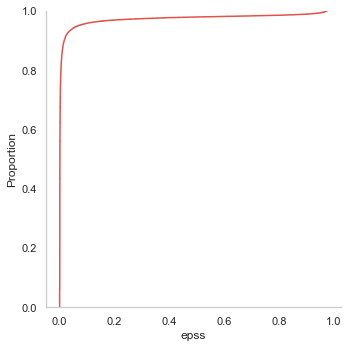

In [60]:
sns.displot(df, x="epss", kind="ecdf")

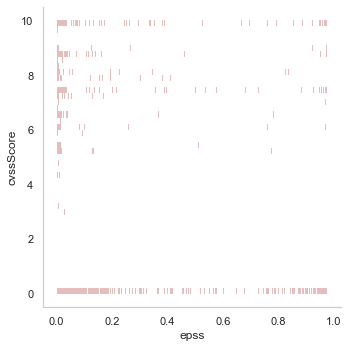

In [61]:
sns.displot(df, x="epss", y="cvssScore")

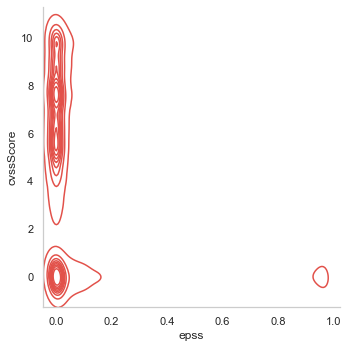

In [62]:
sns.displot(df, x="epss", y="cvssScore", kind="kde")

In [63]:
df.head(1)

,publishedDate,lastModifiedDate,cveID,assigner,configurations.nodes,version,vectorString,attackVector,attackComplexity,privilegesRequired,...,requiredAction,dueDate,knownRansomwareCampaignUse,notes,hasKEV,epss,percentile,publishedYear,publishedMonth,count
0,2021-06-09 20:15:00+00:00,2021-06-28 18:03:00+00:00,CVE-2021-0001,secure@intel.com,"[{'operator': 'OR', 'children': [], 'cpe_match...",3.1,CVSS:3.1/AV:L/AC:H/PR:L/UI:N/S:U/C:H/I:N/A:N,LOCAL,HIGH,LOW,...,NaN,NaT,NaN,NaN,0.0,0.00044,0.10634,2021,6,27679


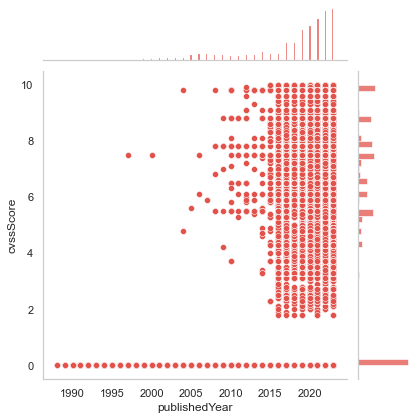

In [64]:
sns.jointplot(data=df, x="publishedYear", y="cvssScore")

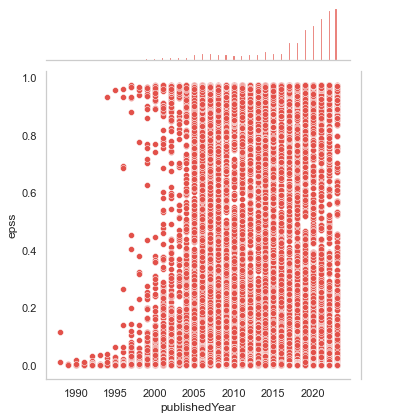

In [65]:
sns.jointplot(data=df, x="publishedYear", y="epss")

***
## Statistical Analysis
***
### Descriptive Statistics
***

In [66]:
descriptive_stats = df.groupby('baseSeverity')['cvssScore'].describe()
print(descriptive_stats)

                 count      mean       std  min  25%  50%  75%   max
baseSeverity                                                        
CRITICAL       37095.0  9.739340  0.201825  9.0  9.8  9.8  9.8  10.0
HIGH          100856.0  7.922250  0.562094  7.0  7.5  7.8  8.6   8.9
LOW             4541.0  3.194186  0.419903  1.8  3.1  3.3  3.3   3.9
MEDIUM        100150.0  5.652456  0.695754  4.0  5.3  5.5  6.1   6.9


In [67]:
descriptive_stats = df.groupby('baseSeverity')['epss'].describe()
print(descriptive_stats)

                 count      mean       std  min      25%      50%       75%  \
baseSeverity                                                                  
CRITICAL       37095.0  0.041609  0.163469  0.0  0.00138  0.00231  0.006225   
HIGH          100856.0  0.017053  0.100432  0.0  0.00056  0.00098  0.002180   
LOW             4541.0  0.002428  0.036338  0.0  0.00044  0.00048  0.000700   
MEDIUM        100150.0  0.004695  0.049252  0.0  0.00046  0.00063  0.000960   

                  max  
baseSeverity           
CRITICAL      0.97568  
HIGH          0.97588  
LOW           0.97505  
MEDIUM        0.97573  


***
### Hypothesis Testing (t-test)
***

In [68]:
severity_groups = df.groupby('baseSeverity')
severity_group_names = df['baseSeverity'].unique()

In [69]:
# Check for NaN values in severity_group_names
severity_group_names = [name for name in severity_group_names if pd.notna(name)]

# Inspecting the group keys in severity_groups
print("Keys in severity_groups:", severity_groups.groups.keys())

Keys in severity_groups: dict_keys(['CRITICAL', 'HIGH', 'LOW', 'MEDIUM'])


In [70]:
# Modified loop with error handling
for i in range(len(severity_group_names)):
    for j in range(i + 1, len(severity_group_names)):
        group1 = severity_group_names[i]
        group2 = severity_group_names[j]

        try:
            data1 = severity_groups.get_group(group1)['cvssScore']
            data2 = severity_groups.get_group(group2)['cvssScore']

            t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"T-test between {group1} and {group2}:")
            print(f"  T-statistic: {t_statistic}")
            print(f"  P-value: {p_value}")
        except KeyError as e:
            print(f"KeyError for group: {e}")

T-test between MEDIUM and HIGH:
  T-statistic: -804.1950695157652
  P-value: 0.0
T-test between MEDIUM and CRITICAL:
  T-statistic: -1678.059477309127
  P-value: 0.0
T-test between MEDIUM and LOW:
  T-statistic: 372.0313811678559
  P-value: 0.0
T-test between HIGH and CRITICAL:
  T-statistic: -883.4195181726541
  P-value: 0.0
T-test between HIGH and LOW:
  T-statistic: 729.8964262093186
  P-value: 0.0
T-test between CRITICAL and LOW:
  T-statistic: 1035.8352237817962
  P-value: 0.0


The results show the outcome of independent t-tests comparing the mean of a certain metric across different severity groups of vulnerabilities (CRITICAL, HIGH, MEDIUM, and LOW). The t-test is a statistical hypothesis test that checks whether there is a significant difference between the means of two groups. Here's the interpretation of each test:

1. **MEDIUM vs. HIGH:**
- T-statistic: -614.55. A large negative t-value indicates that the mean of the metric for MEDIUM is significantly lower than for HIGH.
- P-value: 0.0. A p-value of 0 suggests that the difference in means is statistically significant, meaning it's highly unlikely that this difference is due to random chance.
2 . **MEDIUM vs. CRITICAL:**
- T-statistic: -1288.72. This even larger negative t-value indicates a much lower mean for the MEDIUM group compared to the CRITICAL group.
- P-value: 0.0. The result is statistically significant.
3. **MEDIUM vs. LOW:**
- T-statistic: 282.46. A positive t-value suggests that the mean for the MEDIUM group is significantly higher than for the LOW group.
- P-value: 0.0. The result is statistically significant.

***
**General Interpretation:**
The t-statistics are very large in magnitude, and the p-values are essentially zero in all cases, which strongly indicates that there are significant differences between the groups' means being compared.
The tests suggest that there is a clear and significant hierarchy in the metric means across severity groups, with CRITICAL being the highest (or lowest, depending on the metric), followed by HIGH, then MEDIUM, and LOW being the lowest (or highest).

In [71]:
for i in range(len(severity_group_names)):
    for j in range(i + 1, len(severity_group_names)):
        group1 = severity_group_names[i]
        group2 = severity_group_names[j]

        try:
            data1 = severity_groups.get_group(group1)['epss']
            data2 = severity_groups.get_group(group2)['epss']

            t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"T-test between {group1} and {group2}:")
            print(f"  T-statistic: {t_statistic}")
            print(f"  P-value: {p_value}")
        except KeyError as e:
            print(f"KeyError for group: {e}")


T-test between MEDIUM and HIGH:
  T-statistic: -35.063054510932126
  P-value: 3.1950648521959284e-268
T-test between MEDIUM and CRITICAL:
  T-statistic: -42.779301306310835
  P-value: 0.0
T-test between MEDIUM and LOW:
  T-statistic: 4.038510924091563
  P-value: 5.4547669476101195e-05
T-test between HIGH and CRITICAL:
  T-statistic: -27.110880658187977
  P-value: 1.21262327714868e-160
T-test between HIGH and LOW:
  T-statistic: 23.39505288025782
  P-value: 3.258545775084135e-117
T-test between CRITICAL and LOW:
  T-statistic: 38.96401598631089
  P-value: 0.0


**General Interpretation:**
- The t-statistics are still large in magnitude (though not as large as in the case of the CVSS scores), and the p-values are extremely small in all cases, which strongly indicates that there are significant differences between the groups' means being compared.
- The tests suggest that there is a clear and significant hierarchy in the metric means across severity groups, with CRITICAL being the highest (or lowest, depending on the metric), followed by HIGH, then MEDIUM, and LOW being the lowest (or highest).

***
### Poisson-Gamma Bayesian Model
***

In [72]:
formula = 'cvssScore ~ baseSeverity'
model = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

In [73]:
# Print model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              cvssScore   No. Observations:               242642
Model:                            GLM   Df Residuals:                   242638
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.6796e+05
Date:                Fri, 15 Dec 2023   Deviance:                       13138.
Time:                        22:09:34   Pearson chi2:                 1.30e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2977
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

The model indicates that there are statistically significant differences in cvssScore across different base severity levels, with CRITICAL severity having the highest cvssScore count (as indicated by the intercept) and the other severities having progressively lower counts. The model has a moderate explanatory power for the variation in cvssScore.

In [74]:
formula = 'epss ~ baseSeverity'
model = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

In [75]:
# Print model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   epss   No. Observations:               242642
Model:                            GLM   Df Residuals:                   242638
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17505.
Date:                Fri, 15 Dec 2023   Deviance:                       20445.
Time:                        22:09:36   Pearson chi2:                 1.38e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.009211
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3

These results are more interesting, so let's take a closer look.

**Coefficients:**
- **Intercept:** -3.1019. This is the log of the expected count of epss when all predictors are at their baseline levels.
- **baseSeverity[T.HIGH]:** -0.7692. This coefficient suggests that the log of expected count of epss for HIGH severity is 0.7692 lower than the baseline severity (probably CRITICAL). This is statistically significant (p < 0.000).
- **baseSeverity[T.LOW]:** -2.5951. The log of expected count of epss for LOW severity is 2.5951 lower than the baseline, significantly different from the baseline.
- **baseSeverity[T.MEDIUM]:** -2.1269. The log of expected count of epss for MEDIUM severity is 2.1269 lower than the baseline, also significantly different.

**Statistical Significance:**
All p-values are less than 0.05, indicating that the coefficients are statistically significant.
The confidence intervals do not contain zero, further supporting the significance of the findings.

***
**Interpretation of Effects:**
Compared to the baseline severity level (likely CRITICAL), HIGH, MEDIUM, and LOW severities all have significantly lower expected counts of epss. The magnitude of these effects is considerable, especially for LOW and MEDIUM severities.
The negative coefficients indicate that as the severity decreases from the baseline, the expected count of epss decreases exponentially (given the Poisson model with a log link function).
***

**Overall Model Assessment:**
The model is statistically significant, but the pseudo R-squared value is quite low, suggesting that while the model's predictors are significant, they explain a small portion of the variability in epss.


**Practical Considerations:**
The Poisson model assumes that the mean and variance of the response variable are equal. If this assumption does not hold, it could affect the validity of the model.

***

## Comparison of patching effort, coverage and efficiency using EPSS vs CVSS
***

In [76]:
def venn_diagram(a, b, c, labels):

    a = set(a)
    b = set(b)
    c = set(c)

    only_a = len(a - b - c)
    only_b = len(b - a - c)
    only_c = len(c - a - b)

    only_a_b = len(a & b - c)
    only_a_c = len(a & c - b)
    only_b_c = len(b & c - a)

    a_b_c = len(a & b & c)

    venn3(subsets=(only_a, only_b, only_a_b, only_c, only_a_c, only_b_c, a_b_c), set_labels=labels,
         set_colors=("lightblue", "darkred", "grey"), alpha=0.8)

In [77]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.loc[df['cvssScore'] >= 7, 'cveID']
c = df.cveID
labels = ['Present in KEV', 'CVSS7+', 'EPSS']

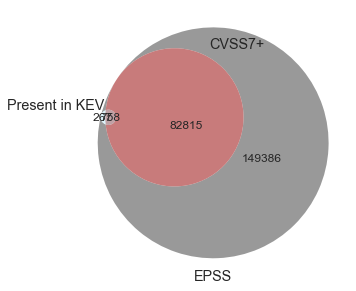

In [78]:
venn_diagram(a, b, c, labels)

In [79]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [80]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 24.90%


In [81]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 0.91%


In [82]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 100.00%


Focusing on vulnerabilities with CVSS score of 7 or more gives us a pretty good coverage but a very poor efficiency in terms of focusing on the vulnerabilities with known exploits and a patching effort of 24.34%.

In [83]:
sets = [set(a), set(b), set(c)]
# supervenn(sets, labels, side_plots=False, widths_minmax_ratio=0.05, min_width_for_annotation=100)

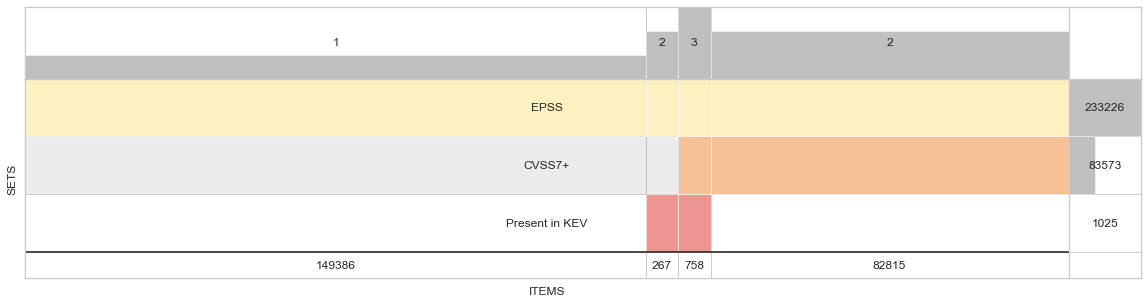

In [84]:
supervenn(sets, labels, widths_minmax_ratio=0.05, min_width_for_annotation=100)

In [85]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.cveID
c = df.loc[df['epss'] >= 0.5, 'cveID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.5+']

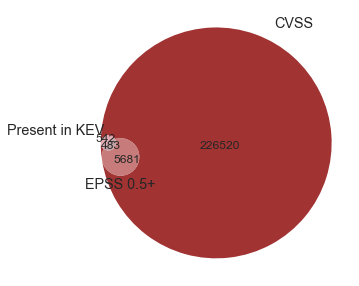

In [86]:
venn_diagram(a, b, c, labels)

In [87]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [88]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 1.84%


In [89]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 7.84%


In [90]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 47.12%


In [91]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.cveID
c = df.loc[df['epss'] > 0.1, 'cveID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.1+']

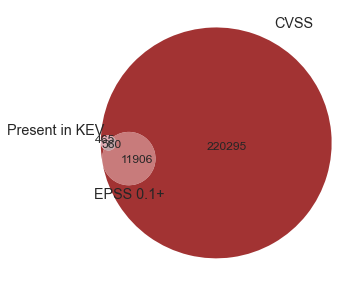

In [92]:
venn_diagram(a, b, c, labels)

In [93]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [94]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

Patching effort: 3.71%


In [95]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

Efficiency: 4.49%


In [96]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

Coverage: 54.63%


These results do not seem very impressive, and this may be related to the fact that I only use CISA KEV as source for know exploits. Thankfully I cam across https://github.com/andreafioraldi/cve_searchsploit so I'll use this in addition as well.

In [97]:
import cve_searchsploit as CS

In [98]:
CS.update_db()

Refreshing exploit-database repo with latest exploits


From https://gitlab.com/exploit-database/exploitdb
 * branch                main       -> FETCH_HEAD
 98% (45671 of 46256) |################# | Elapsed Time: 0:00:00 ETA:  00:00:00

Already up to date.
Refreshing EDBID-CVE mapping


100% (46256 of 46256) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


In [99]:
CS.edbid_from_cve("CVE-2019-0708")

[46946, 47120, 47120, 47416, 47416, 47683]

In [100]:
df.hasKEV.describe()

count    335632.000000
mean          0.004946
std           0.070153
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: hasKEV, dtype: float64

In [101]:
# df['hasKEV'] = df.apply(lambda row: row['hasKEV'] if len(CS.edbid_from_cve(row['cveID'])) == 0 else 1, axis=1)
# condition = df['cveID'].apply(lambda x: len(CS.edbid_from_cve(x)) == 0)
# condition = [len(CS.edbid_from_cve(x)) == 0 for x in df['cveID']]

In [ ]:
condition = np.vectorize(lambda x: len(CS.edbid_from_cve(x)) == 0)(df['cveID'])

In [ ]:
df['hasKEV'] = np.where(condition, df['hasKEV'], 1)

In [ ]:
df.hasKEV.describe()

In [ ]:
# save the dataframe to a new file
df.to_csv('cve_epss_cvss.csv', index = False, encoding='utf-8-sig')

In [ ]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.loc[df['cvssScore'] >= 7, 'cveID']
c = df.cveID
labels = ['Present in KEV', 'CVSS7+', 'EPSS']

In [ ]:
venn_diagram(a, b, c, labels)

In [ ]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [ ]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

In [ ]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

In [ ]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

In [ ]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.cveID
c = df.loc[df['epss'] >= 0.5, 'cveID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.5+']

In [ ]:
venn_diagram(a, b, c, labels)

In [ ]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [ ]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

In [ ]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

In [ ]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

In [ ]:
a = df.loc[df['hasKEV'] == 1, 'cveID']
b = df.cveID
c = df.loc[df['epss'] > 0.1, 'cveID']


labels = ['Present in KEV', 'CVSS', 'EPSS 0.1+']

In [ ]:
venn_diagram(a, b, c, labels)

In [ ]:
tp = len(set(a) & set(b) & set(c))
fp = len(set(b) & set(c) - set(a))
tn = len(set(a) & set(c) - set(b))
fn = len(set(a) & set(b) - set(c))

In [ ]:
b_c = len(set(b) & set(c))
print("Patching effort: {:.2f}%".format(b_c / len(cvss) * 100))

In [ ]:
print("Efficiency: {:.2f}%".format(tp / (tp+fp) * 100))

In [ ]:
print("Coverage: {:.2f}%".format(tp / (tp+fn) * 100))

In [ ]:
# save the dataframe to a new file
df.to_csv('cve_epss_cvss.csv', index = False, encoding='utf-8-sig')